<a href="https://colab.research.google.com/github/Conradtokoyo/MNIST-Data/blob/main/Fastai_Kaggle_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MNIST model with Fastai

This notebook installs fast AI and grabs the MNIST dataset from Kaggle. It then trains and tests a model using fast ai and creates a csv file for submission to Kaggle.

Most of the foundation of the code was from lesson 2 of fastai's Practical Deep Learning for Coders found here https://course.fast.ai/.


In [1]:
#hide
#install and import fastbook to colab
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.8MB/s 
     |████████████████████████████████| 1.2MB 56.4MB/s 
     |████████████████████████████████| 194kB 53.7MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 12.8MB 40.8MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [2]:
#hide
#import fast ai 
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *

##Load Kaggle Data

This step requires a JSON file  generated from your user account.

Instructions can be found here:
<br>
https://towardsdatascience.com/how-to-use-kaggle-datasets-in-google-colab-bca5e452a676 

In [3]:
#Loading the json kaggle file to access kaggle data

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [4]:
#install mnist data
!kaggle competitions download -c digit-recognizer
!unzip train.csv.zip
!unzip test.csv.zip

  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 39.0MB/s]
 55% 5.00M/9.16M [00:00<00:00, 13.8MB/s]
100% 9.16M/9.16M [00:00<00:00, 23.0MB/s]
 82% 5.00M/6.09M [00:00<00:00, 13.5MB/s]
100% 6.09M/6.09M [00:00<00:00, 15.4MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [5]:
#Import pandas and read training and testing data in dataframes
import pandas as pd 
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [6]:
#create a dataframe to store labels, another without labels, df with values only, test value df and a path variable to set location of where to store images
label_df = train['label']
mod_train = train.drop(columns= 'label')
data_values = mod_train.values
test_data_values = test.values
PATH = Path('/content/gdrive/My Drive/mnist') 


#Create jpg images to train / validate / test model

In [7]:
for i in range(0, len(data_values)):

    #read the correct label
    correct_label = label_df[i]

    #split the data into training and validation sets
    if np.random.rand() < 0.8:
        folder = '/train/'
        train_path = f'{PATH}' + '/train/' + str(correct_label)
        if not os.path.exists(train_path):
          os.makedirs(train_path)

    else:
        folder = '/valid/'
        valid_path = f'{PATH}' + '/valid/' + str(correct_label)
        if not os.path.exists(valid_path):
          os.makedirs(valid_path)
    
    img = data_values[i][:]

    #reshape into 28x28 pic
    img = img.reshape(28,28)

    #we need three channels into the picture
    img = np.stack((img,)*3,axis = -1)

    #change the data type to int8
    img = np.uint8(img)

    #create PIL Image
    new_img = Image.fromarray(img)

    #save the .jpg into correct folder
    new_img.save(f'{PATH}' + folder + str(correct_label) + '/' + str(i) + '.jpg', 'JPEG')

Create test images from test_data_values

In [8]:
for i in range(0, len(test_data_values)):

    #create test images
    folder = '/test/'
    test_path = f'{PATH}' + '/test/' 
    if not os.path.exists(test_path):
      os.makedirs(test_path)
    
    img = test_data_values[i][:]

    #reshape into 28x28 pic
    img = img.reshape(28,28)

    #we need three channels into the picture
    img = np.stack((img,)*3,axis = -1)

    #change the data type to int8
    img = np.uint8(img)

    #create PIL Image
    new_img = Image.fromarray(img)

    #save the .jpg into correct folder
    new_img.save(f'{PATH}' + folder + str(i) + '.jpg', 'JPEG')

##Train Model

In [9]:
mnist = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    splitter = GrandparentSplitter(train_name = "train", valid_name = "valid"),
    get_y=parent_label,
    item_tfms=Resize(224))

dls = mnist.dataloaders(PATH)

In [11]:
mnist = mnist.new(
        item_tfms = RandomResizedCrop(224, min_scale = 0.5),
        batch_tfms = aug_transforms())
dls = mnist.dataloaders(PATH,bs = 32)

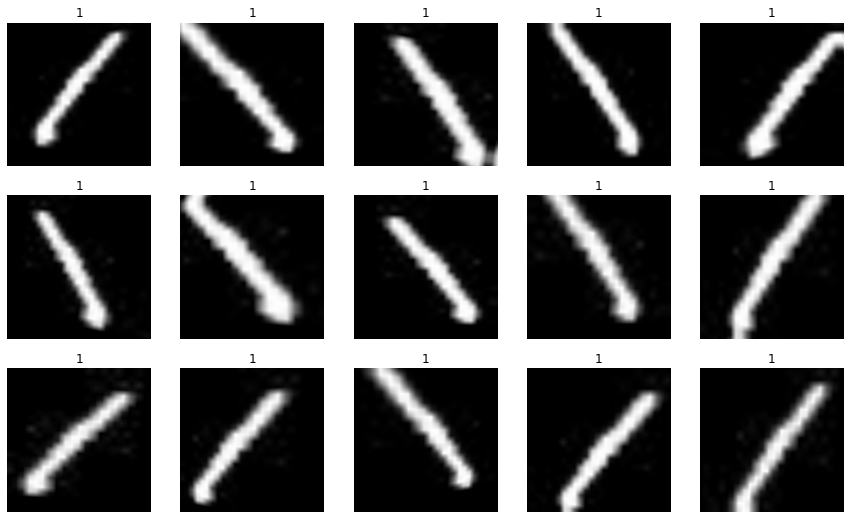

In [12]:
dls.train.show_batch(max_n = 15, nrows = 3, unique = True)

In [13]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [15]:
learn.fit_one_cycle(2, 0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.397439,1.018332,0.053783,0.946217,02:28
1,0.257265,0.131699,0.023067,0.976933,02:29


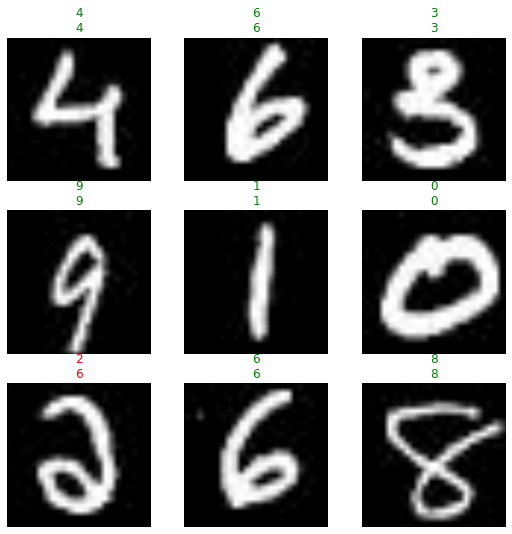

In [16]:
learn.show_results()

### Exporting Model

In [17]:
learn.export(fname = str(PATH) + "/mnist_model.pkl")

In [18]:
learn_inf = load_learner(str(PATH) + "/mnist_model.pkl")

## Testing the model

In [19]:
#exported model predictions - steps

#get images to run
folder ='/content/gdrive/My Drive/mnist/test/'
images = get_image_files(folder)

#get model name
name = '/mnist_model.pkl'

#load model with file/path
modelex = str(PATH) + name

#load exported model
learn = load_learner(modelex)

#pass in images to create test batch
dl = learn.dls.test_dl(images)

In [20]:
#get preds for batch
pred_tensor, ignored, preds = learn.get_preds(dl=dl, with_decoded=True)

In [21]:
result = np.argmax(pred_tensor, 1)

##Preparing Submission

In [22]:
final = pd.Series(result,name='Label')
submission = pd.concat([pd.Series(range(1,28001),name='ImageId'),final],axis=1)
submission.to_csv(str(PATH) + '/fastai-pytorch-mnist.csv',index=False)

#Citations

Resources that contributed code to this notebook:
<br>
1. https://www.kaggle.com/stefanbuenten/mnist-test-with-fastai
<br>
2. https://www.kaggle.com/daneiref/yet-another-mnist-using-fastai